# MNSIT

In [45]:
# 引入MNIST数据集
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", data_home="./datasets")

X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


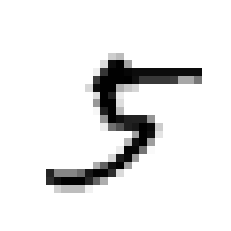

label is:  5


In [46]:
# 查看其中的图像
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36011]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("label is: ", y[36011])

In [47]:
# 准备训练集和测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000].astype("int"), y[60000:].astype("int") # label转为数字方便后面的处理

# 将原数据打乱防止算法对顺序敏感, 做交叉验证的时候每一折含有的数字随机, 不会有缺漏
import numpy as np
shuffle_indices = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]

## 训练二分器
判断数字是否为5

In [48]:
y_train_5 = (y_train == 5) # 生成每个元素是否为5(True/False)的数组
y_test_5 = (y_test == 5)
y_train_5[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

### 使用随机梯度分类器SGDClassifier

In [49]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # random_state可以用来控制随机度, 一样的值会产生一样的训练结果
sgd_clf.fit(X_train, y_train_5)

# 验证
sgd_clf.predict([some_digit])

array([ True])

## 对性能进行评估 

### 使用交叉验证法

In [53]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=10, scoring="accuracy") 
scores

array([0.9601733 , 0.96066667, 0.95933333, 0.91833333, 0.96583333,
       0.96133333, 0.96516667, 0.96466667, 0.936     , 0.96749458])